In [37]:
import pandas as pd
import numpy as np

In [38]:
df = pd.read_csv('inventory_train.csv')

df = df[df['item'] == 1]
df['date'] = pd.to_datetime(df['date']) - pd.to_timedelta(7, unit='d')
df = df.filter(['date', 'sales']).groupby([pd.Grouper(key='date', freq='W-MON')]).sum().reset_index()
print(df.head()) # NOW WE HAVE SALES FOR ITEM 1 GROUPED IN WEEKS

        date  sales
0 2012-12-31    894
1 2013-01-07    863
2 2013-01-14    867
3 2013-01-21    816
4 2013-01-28    969


In [39]:
df['shift_sale'] = df['sales'].shift(-1)
df = df.iloc[:-1]
df

,date,sales,shift_sale
0,2012-12-31,894,863.0
1,2013-01-07,863,867.0
2,2013-01-14,867,816.0
3,2013-01-21,816,969.0
4,2013-01-28,969,920.0
...,...,...,...
255,2017-11-20,1818,1490.0
256,2017-11-27,1490,1311.0
257,2017-12-04,1311,1308.0
258,2017-12-11,1308,1262.0


In [40]:
def four_week_avg(sales):
    sum = 0
    week_avg = []
    for i in range(3, -1, -1):
        for j in range(i):
            sum += sales[j]
        if(i!=0):
            week_avg.append(sum/i)
        sum = 0
    week_avg.append(sales[0])
    week_avg.reverse()
    for row in range(len(sales) - 4):
        for row in range(row, row + 4):
            sum += sales[row]
        week_avg.append(sum / 4)
        sum = 0
    return week_avg

In [41]:
df['week_avg'] = four_week_avg(df['sales'].tolist())
print(df.head())


        date  sales  shift_sale    week_avg
0 2012-12-31    894       863.0  894.000000
1 2013-01-07    863       867.0  894.000000
2 2013-01-14    867       816.0  878.500000
3 2013-01-21    816       969.0  874.666667
4 2013-01-28    969       920.0  860.000000


In [42]:
df=df.drop('date', axis=1)
df.describe()

,sales,shift_sale,week_avg
count,260.000000,260.000000,260.000000
mean,1539.296154,1540.346154,1535.263141
std,329.349776,327.715686,325.182824
min,816.000000,816.000000,860.000000
25%,1281.250000,1281.250000,1288.375000
50%,1560.500000,1560.500000,1547.625000
75%,1782.750000,1782.750000,1786.062500
max,2290.000000,2290.000000,2244.000000


In [43]:
test = df.iloc[-52:]
df = df.iloc[:-52]
df.head()

,sales,shift_sale,week_avg
0,894,863.0,894.000000
1,863,867.0,894.000000
2,867,816.0,878.500000
3,816,969.0,874.666667
4,969,920.0,860.000000


In [44]:
test.head()

,sales,shift_sale,week_avg
208,1261,1182.0,1314.50
209,1182,1216.0,1257.75
210,1216,1207.0,1244.25
211,1207,1141.0,1230.00
212,1141,1288.0,1216.50


In [45]:
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, max_error

In [46]:
X = df.drop('sales', axis=1)
y = df['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVR(C=1, kernel="linear", degree=8, gamma='scale', coef0=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f'Model fit results:\n'
      f'r2_score {r2_score(y_test, predictions)} \t MSE {mean_squared_error(y_test, predictions)}'
      f'\tEVS {explained_variance_score(y_test, predictions)} \n MAE {mean_absolute_error(y_test, predictions)}'
      f'\tMAD {median_absolute_error(y_test, predictions)}\t ME {max_error(y_test, predictions)}')

Model fit results:
r2_score 0.9289992403898505 	 MSE 5041.803062784257	EVS 0.9324982412884245 
 MAE 55.074051376468624	MAD 49.19111044704914	 ME 225.74290596956553


In [47]:
predictions = clf.predict(test.drop('sales', axis=1))
predictions = pd.DataFrame(predictions, columns=['sales'])
predictions.head()

,sales
0,1230.997608
1,1237.055537
2,1226.728063
3,1176.915327
4,1274.024951


In [48]:
print(f'Model test results:\n'
      f'r2_score {r2_score(test["sales"], predictions)} \t MSE {mean_squared_error(test["sales"], predictions)}'
      f'\tEVS {explained_variance_score(test["sales"], predictions)} \n MAE {mean_absolute_error(test["sales"], predictions)}'
      f'\tMAD {median_absolute_error(test["sales"], predictions)}\t ME {max_error(test["sales"], predictions)}')


Model test results:
r2_score 0.9371923564047144 	 MSE 6201.042761524669	EVS 0.9373439750800469 
 MAE 60.640658575139575	MAD 52.170644741505384	 ME 242.0610369641131


In [49]:
test['weeks']=range(0,52)
test = test [['weeks','sales','shift_sale','week_avg']]

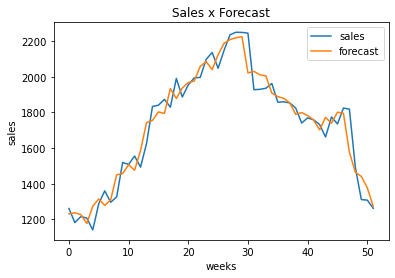

In [50]:
xx = test['weeks']
plt.plot('weeks', 'sales', data=test)
plt.plot(xx, 'sales', data=predictions)
plt.xlabel('weeks')
plt.ylabel('sales')
plt.title('Sales x Forecast')
plt.legend(labels=['sales','forecast'])